# Colapse all simulation into a unique .feather file

In [1]:
import glob, os
import pandas as pd
import numpy as np

df_complete_file = 'df_complete_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex1/SummaryFile_*.csv')
    df_all = pd.concat((pd.read_csv(file, sep='\t', encoding='utf-8') for file in data_files), ignore_index=True)
    df_all.to_feather(df_complete_file)
df_all # 3097600 rows = 2560 samples * 10 repplicates * 121 time points

df_complete_ex1.feather already exists. Reading it.


,Unnamed: 0,time,replicate,sample,runtime,tumor_live,tumor_dead,motile_live,motile_dead,dist_mean_tumor_live,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0,0.0,9,1426,0.000017,2000,0,0,0,249.698882,...,0.000780,20.688183,4.704027,0.220392,3.293232,3.56702,9.039065,0.004157,6.470086,9.114521
1,0,60.0,9,1426,0.990389,1907,53,45,2,255.357166,...,0.000780,20.688183,4.704027,0.220392,3.293232,3.56702,9.039065,0.004157,6.470086,9.114521
2,0,120.0,9,1426,1.970022,1812,104,90,3,261.206081,...,0.000780,20.688183,4.704027,0.220392,3.293232,3.56702,9.039065,0.004157,6.470086,9.114521
3,0,180.0,9,1426,2.927856,1746,133,126,5,265.915346,...,0.000780,20.688183,4.704027,0.220392,3.293232,3.56702,9.039065,0.004157,6.470086,9.114521
4,0,240.0,9,1426,3.886421,1686,164,154,6,270.310309,...,0.000780,20.688183,4.704027,0.220392,3.293232,3.56702,9.039065,0.004157,6.470086,9.114521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097595,0,6960.0,9,1595,109.258297,1495,173,42,165,338.422240,...,0.000826,20.027634,4.099151,0.206745,2.445844,3.84555,7.974273,0.005909,7.966442,7.973544
3097596,0,7020.0,9,1595,110.181132,1500,171,37,165,338.274575,...,0.000826,20.027634,4.099151,0.206745,2.445844,3.84555,7.974273,0.005909,7.966442,7.973544
3097597,0,7080.0,9,1595,111.101522,1498,171,37,165,338.502224,...,0.000826,20.027634,4.099151,0.206745,2.445844,3.84555,7.974273,0.005909,7.966442,7.973544
3097598,0,7140.0,9,1595,112.026848,1496,176,35,165,338.788435,...,0.000826,20.027634,4.099151,0.206745,2.445844,3.84555,7.974273,0.005909,7.966442,7.973544


# Define the QoIs: AUC of each mean population, weithed mean and pooled std of distance from the center in the last time

- Invasion: Mean and std of cells' distance from the center - measures the average spread of cells and how spread out (variability) the invasion is.
    - Summary over time and replicates: For the last point, take the weighted mean of the means (weights: number of cells) and the pooled std from the stds.
- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.

In [2]:
df_summary_file = 'df_summary_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) ):
    print(f'{df_summary_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
else:
    print(f'{df_summary_file} does not exists. Generating it.')

    # Take the weighted mean and pooled std of replicates in each sample and time
    # Define the weighted mean function
    def weighted_mean(df, value_col, weight_col):
        return (df[value_col] * df[weight_col]).sum(skipna=True) / df[weight_col].sum(skipna=True)
    # Define the pooled standard deviation function
    def pooled_std(df, std_col, weight_col):
        variance = ((df[weight_col]-1) * df[std_col]** 2).sum(skipna=True) / (df[weight_col]-1).sum(skipna=True)
        return np.sqrt(variance)

    # Apply the weighted mean and pooled std to the desired columns
    pop_cols = ['tumor_live', 'tumor_dead', 'motile_live', 'motile_dead']
    mean_cols = ['dist_mean_tumor_live', 'dist_mean_tumor_dead', 'dist_mean_motile_live', 'dist_mean_motile_dead']
    std_cols = ['dist_std_tumor_live', 'dist_std_tumor_dead', 'dist_std_motile_live', 'dist_std_motile_dead']

    weighted_means = df_all.groupby(['sample', 'time']).apply(lambda x: pd.Series({f'weighted_mean_{col_wei}': weighted_mean(x, col_mean, col_wei) for col_mean, col_wei in zip(mean_cols,pop_cols)}))
    pooled_stds = df_all.groupby(['sample', 'time']).apply(lambda x: pd.Series({f'pooled_std_{col_wei}': pooled_std(x, col_std, col_wei) for col_std, col_wei in zip(std_cols,pop_cols)}))

    df_samples_mean = df_all.groupby(['sample', 'time'], as_index=False).mean()
    df_samples_mean = df_samples_mean.merge(weighted_means, on=['sample', 'time'])
    df_samples_mean = df_samples_mean.merge(pooled_stds, on=['sample', 'time'])
    df_samples_mean = df_samples_mean.drop(columns=['Unnamed: 0','replicate'])
    
    # Function to calculate AUC using trapezoidal rule for trajectories
    def calculate_auc_multiple(group):
        auc_values = {}
        columns = [col for col in df_samples_mean.columns if col.startswith('weighted_mean_')]
        for col in columns: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapezoid(group[col][mask_notna], group['time'][mask_notna])
        return pd.Series(auc_values)
    # Group by 'Sample_ID' then calculate AUC for each QOI
    df_auc = df_samples_mean.groupby(['sample']).apply(calculate_auc_multiple).reset_index() # calculate the AUC for each QOI
    
    # Filter the dataframe to last time point
    df_summary = df_samples_mean[ df_samples_mean['time'] == 7200.0 ]
    # Merge the AUC values of trajectories
    df_summary = df_summary.merge(df_auc, on=['sample'])

    df_summary.to_feather(df_summary_file)

df_summary

df_summary_ex1.feather already exists. Reading it.


,sample,time,runtime,tumor_live,tumor_dead,motile_live,motile_dead,dist_mean_tumor_live,dist_mean_tumor_dead,dist_mean_motile_live,...,weighted_mean_motile_live,weighted_mean_motile_dead,pooled_std_tumor_live,pooled_std_tumor_dead,pooled_std_motile_live,pooled_std_motile_dead,AUC_weighted_mean_tumor_live,AUC_weighted_mean_tumor_dead,AUC_weighted_mean_motile_live,AUC_weighted_mean_motile_dead
0,0,7200.0,113.815152,1351.8,436.5,33.3,56.1,334.807646,191.655718,249.596908,...,249.836967,170.631107,64.838811,82.625876,70.153594,69.730478,2.291663e+06,1.267223e+06,1.658736e+06,1.154242e+06
1,1,7200.0,113.436892,1350.8,442.0,39.8,55.2,336.224423,191.664134,251.572273,...,250.389598,162.995680,64.546993,81.696741,75.589863,67.453708,2.293356e+06,1.266562e+06,1.662441e+06,1.095716e+06
2,2,7200.0,113.025856,1373.3,441.7,40.9,56.0,338.162652,190.174151,258.296258,...,258.591709,166.450441,64.279200,81.381424,76.089114,70.802965,2.298135e+06,1.259697e+06,1.673227e+06,1.124338e+06
3,3,7200.0,112.988236,1357.7,433.2,37.0,60.4,335.934277,190.696605,255.487084,...,255.010642,156.787911,64.538814,79.425479,68.071834,69.732351,2.294130e+06,1.267641e+06,1.658325e+06,1.053958e+06
4,4,7200.0,113.176357,1374.8,430.9,38.6,58.7,336.225783,191.798370,262.405690,...,262.312709,162.586479,65.371266,81.290987,75.389477,69.726835,2.294881e+06,1.269654e+06,1.668343e+06,1.106114e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,2555,7200.0,111.637399,1399.7,427.5,45.2,65.8,345.560974,209.132306,260.067996,...,259.669013,165.024852,64.165652,87.275399,71.492759,69.002187,2.350022e+06,1.349804e+06,1.659562e+06,1.116809e+06
2556,2556,7200.0,111.811061,1387.6,426.9,46.2,80.1,345.944667,209.344094,260.283486,...,261.231242,168.596901,63.639633,87.863988,72.709435,73.605702,2.351673e+06,1.350176e+06,1.663700e+06,1.132224e+06
2557,2557,7200.0,111.696290,1384.3,470.8,37.9,66.0,338.380276,198.466228,254.426181,...,253.844288,155.581668,65.818760,84.036059,73.870758,68.162892,2.292079e+06,1.294596e+06,1.666723e+06,1.045879e+06
2558,2558,7200.0,111.077300,1387.8,428.6,45.7,81.0,345.483377,206.251312,258.922216,...,258.203779,165.713904,63.991741,87.206832,70.645684,72.620233,2.342737e+06,1.341415e+06,1.680753e+06,1.111947e+06


Text(0.5, 0, 'Sample')

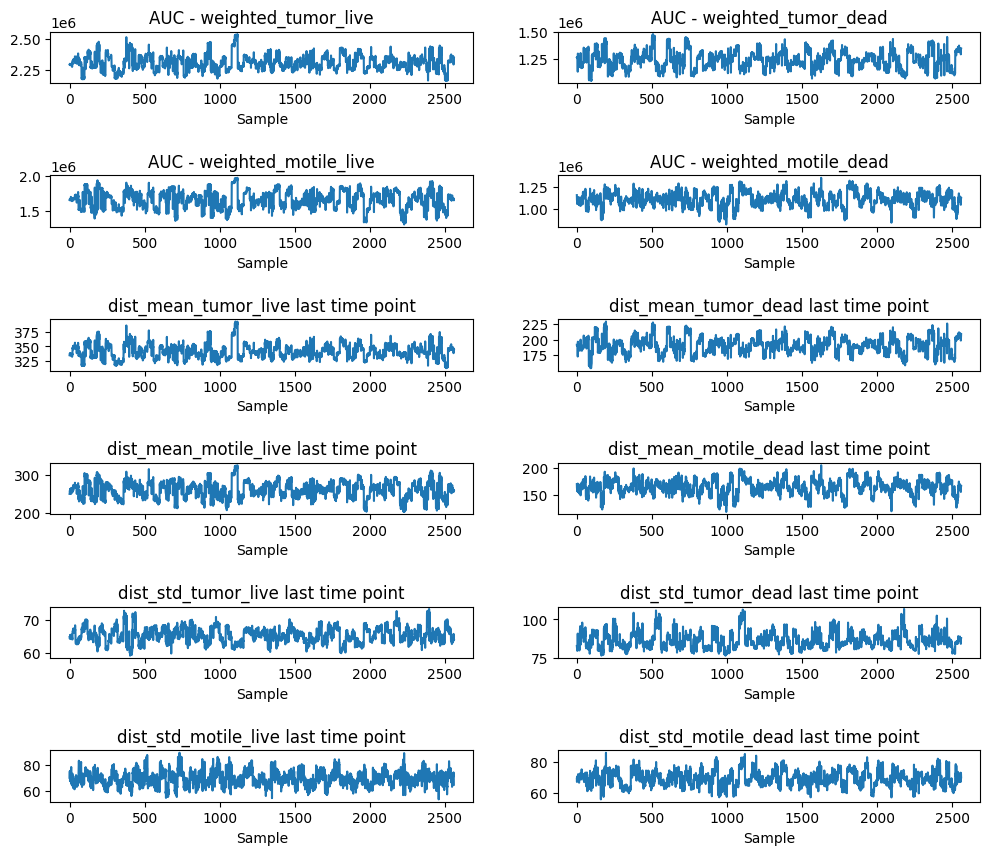

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=1.8)
axes[0, 0].plot(df_summary['sample'], df_summary['AUC_weighted_mean_tumor_live'])
axes[0, 0].set_title('AUC - weighted_tumor_live')
axes[0, 0].set_xlabel('Sample')
axes[0, 1].plot(df_summary['sample'], df_summary['AUC_weighted_mean_tumor_dead'])
axes[0, 1].set_title('AUC - weighted_tumor_dead')
axes[0, 1].set_xlabel('Sample')

axes[1, 0].plot(df_summary['sample'], df_summary['AUC_weighted_mean_motile_live'])
axes[1, 0].set_title('AUC - weighted_motile_live')
axes[1, 0].set_xlabel('Sample')
axes[1, 1].plot(df_summary['sample'], df_summary['AUC_weighted_mean_motile_dead'])
axes[1, 1].set_title('AUC - weighted_motile_dead')
axes[1, 1].set_xlabel('Sample')

axes[2, 0].plot(df_summary['sample'], df_summary['dist_mean_tumor_live'])
axes[2, 0].set_title('dist_mean_tumor_live last time point')
axes[2, 0].set_xlabel('Sample')
axes[2, 1].plot(df_summary['sample'], df_summary['dist_mean_tumor_dead'])
axes[2, 1].set_title('dist_mean_tumor_dead last time point')
axes[2, 1].set_xlabel('Sample')

axes[3, 0].plot(df_summary['sample'], df_summary['dist_mean_motile_live'])
axes[3, 0].set_title('dist_mean_motile_live last time point')
axes[3, 0].set_xlabel('Sample')
axes[3, 1].plot(df_summary['sample'], df_summary['dist_mean_motile_dead'])
axes[3, 1].set_title('dist_mean_motile_dead last time point')
axes[3, 1].set_xlabel('Sample')

axes[4, 0].plot(df_summary['sample'], df_summary['dist_std_tumor_live'])
axes[4, 0].set_title('dist_std_tumor_live last time point')
axes[4, 0].set_xlabel('Sample')
axes[4, 1].plot(df_summary['sample'], df_summary['dist_std_tumor_dead'])
axes[4, 1].set_title('dist_std_tumor_dead last time point')
axes[4, 1].set_xlabel('Sample')

axes[5, 0].plot(df_summary['sample'], df_summary['dist_std_motile_live'])
axes[5, 0].set_title('dist_std_motile_live last time point')
axes[5, 0].set_xlabel('Sample')
axes[5, 1].plot(df_summary['sample'], df_summary['dist_std_motile_dead'])
axes[5, 1].set_title('dist_std_motile_dead last time point')
axes[5, 1].set_xlabel('Sample')

# SA Convergence

In [7]:
from SALib.analyze import sobol
from SALib import ProblemSpec
from uq_physicell.uq_physicell import PhysiCell_Model, get_rule_index_in_csv
import os 

print(os.getcwd())
# Change the directory
os.chdir("/N/slate/hlimadar/grammar_samples")

PhysiCellModel = PhysiCell_Model("Sensitivity_Analysis/ConfigFile.ini", 'model_hypoxia')
# Define parameters of rules in range +/- 20% of the reference value
names_parameters = []
bounds_parameters = []
for key_rule, list_rule in PhysiCellModel.parameters_rules.items():
    id_rule = get_rule_index_in_csv(PhysiCellModel.rules, key_rule)
    parameter_rule = key_rule.split(',')[-1]
    names_parameters.append(list_rule[1])
    bounds_parameters.append([float(PhysiCellModel.rules[id_rule][parameter_rule])*0.8, float(PhysiCellModel.rules[id_rule][parameter_rule])*1.2])
    # id_rule, name, parametername (saturation, half max, or hill power), value of reference
    # print(id_rule, list_rule[1], parameter_rule, PhysiCellModel.rules[id_rule][parameter_rule])

# Define SA problem
problem = {'names': names_parameters, 'bounds': bounds_parameters}
sa_sobol = ProblemSpec(problem)

# Sample parameters 
sa_sobol.sample_sobol(2**6, calc_second_order=True, seed=42) # False: N*(D+2) True: N*(2D+2)

# Define a range of sample sizes
N = np.array([2**1, 2**2, 2**3, 2**4, 2**5, 2**6])
D = sa_sobol.samples.shape[1]
sample_sizes = N*(2*D+2) # False: N*(D+2) True: N*(2D+2)

dic_analyzes = {}
QOI_colums = [col for col in df_summary.columns if ( col.startswith('AUC_') | (col.startswith('dist_')) ) ]
print('QOIs: ', QOI_colums)
# Analyze the multiple QOIs
for col in QOI_colums:
    # Set the results
    sa_sobol.set_results(df_summary[col].to_numpy())
    # Example to plot the first-order indices over sample size
    S1_values = []  # Store first-order indices for each sample size
    ST_values = []  # Store total-order indices for each sample size
    
    # Run Sobol analysis for each sample size using subsets of the large sample set
    for samp_size in sample_sizes:
        # Take the first N samples from the large sample set
        param_values_subset = sa_sobol.samples[:samp_size]
        Y_subset = sa_sobol.results[:samp_size]
        # Perform Sobol analysis on the subset
        Si = sobol.analyze(problem, Y_subset, calc_second_order=True)#, print_to_console=True)
        # Storage results for comparison
        S1_values.append(Si['S1'])
        ST_values.append(Si['ST'])
    
    # Convert to NumPy arrays for plotting
    dic_analyzes[col] = {'S1_values': np.array(S1_values), 'ST_values': np.array(ST_values)}

/N/slate/hlimadar/grammar_samples
QOIs:  ['dist_mean_tumor_live', 'dist_mean_tumor_dead', 'dist_mean_motile_live', 'dist_mean_motile_dead', 'dist_std_tumor_live', 'dist_std_tumor_dead', 'dist_std_motile_live', 'dist_std_motile_dead', 'AUC_weighted_mean_tumor_live', 'AUC_weighted_mean_tumor_dead', 'AUC_weighted_mean_motile_live', 'AUC_weighted_mean_motile_dead']


/N/u/hlimadar/BigRed200/.conda/envs/dask_env/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [8]:
# Convert to DataFrame
dic_to_df = {
    'QOI': [],
    'S1': [],
    'ST': [],
    'sample_size': [],
    'parameter': [],
    'rule_label': [],
    'rule_parameter': []
}

dic_rules = {"cycle_tumor_sat": "Rule 1", "cycle_tumor_hfm": "Rule 1", "cycle_tumor_hp": "Rule 01",
             "mechano_tumor_hfm": "Rule 2", "mechano_tumor_hp": "Rule 2",
             "necrosis_tumor_hfm": "Rule 3", "necrosis_tumor_hp": "Rule 3",
             "tumor2motile_hfm": "Rule 4", "tumor2motile_hp": "Rule 4",
             "cycle_motile_sat": "Rule 5", "cycle_motile_hfm": "Rule 5", "cycle_motile_hp": "Rule 05",
             "mechano_motile_hfm": "Rule 6", "mechano_motile_hp": "Rule 6",
             "necrosis_motile_hfm": "Rule 7", "necrosis_motile_hp": "Rule 7",
             "motile2tumor_sat": "Rule 8", "motile2tumor_hfm": "Rule 8", "motile2tumor_hp": "Rule 8"}

for qoi in dic_analyzes.keys():
    for par_id in range(dic_analyzes[qoi]['S1_values'].shape[1]):
        for sample_id in range(dic_analyzes[qoi]['S1_values'].shape[0]):
            dic_to_df['QOI'].append(qoi)
            dic_to_df['S1'].append(dic_analyzes[qoi]['S1_values'][sample_id, par_id])
            dic_to_df['ST'].append(dic_analyzes[qoi]['ST_values'][sample_id, par_id])
            dic_to_df['sample_size'].append(sample_sizes[sample_id])
            dic_to_df['parameter'].append(problem['names'][par_id])
            dic_to_df['rule_label'].append(dic_rules[problem['names'][par_id]])
            dic_to_df['rule_parameter'].append(problem['names'][par_id].split('_')[-1])

df_analyzes = pd.DataFrame(dic_to_df)
df_analyzes

,QOI,S1,ST,sample_size,parameter,rule_label,rule_parameter
0,dist_mean_tumor_live,0.121503,0.009293,80,cycle_tumor_sat,Rule 1,sat
1,dist_mean_tumor_live,0.014954,0.001502,160,cycle_tumor_sat,Rule 1,sat
2,dist_mean_tumor_live,0.072423,0.003473,320,cycle_tumor_sat,Rule 1,sat
3,dist_mean_tumor_live,0.022582,0.004760,640,cycle_tumor_sat,Rule 1,sat
4,dist_mean_tumor_live,0.022033,0.004046,1280,cycle_tumor_sat,Rule 1,sat
...,...,...,...,...,...,...,...
1363,AUC_weighted_mean_motile_dead,0.144284,0.086974,160,motile2tumor_hp,Rule 8,hp
1364,AUC_weighted_mean_motile_dead,0.143198,0.065284,320,motile2tumor_hp,Rule 8,hp
1365,AUC_weighted_mean_motile_dead,0.150916,0.079179,640,motile2tumor_hp,Rule 8,hp
1366,AUC_weighted_mean_motile_dead,-0.015846,0.065406,1280,motile2tumor_hp,Rule 8,hp


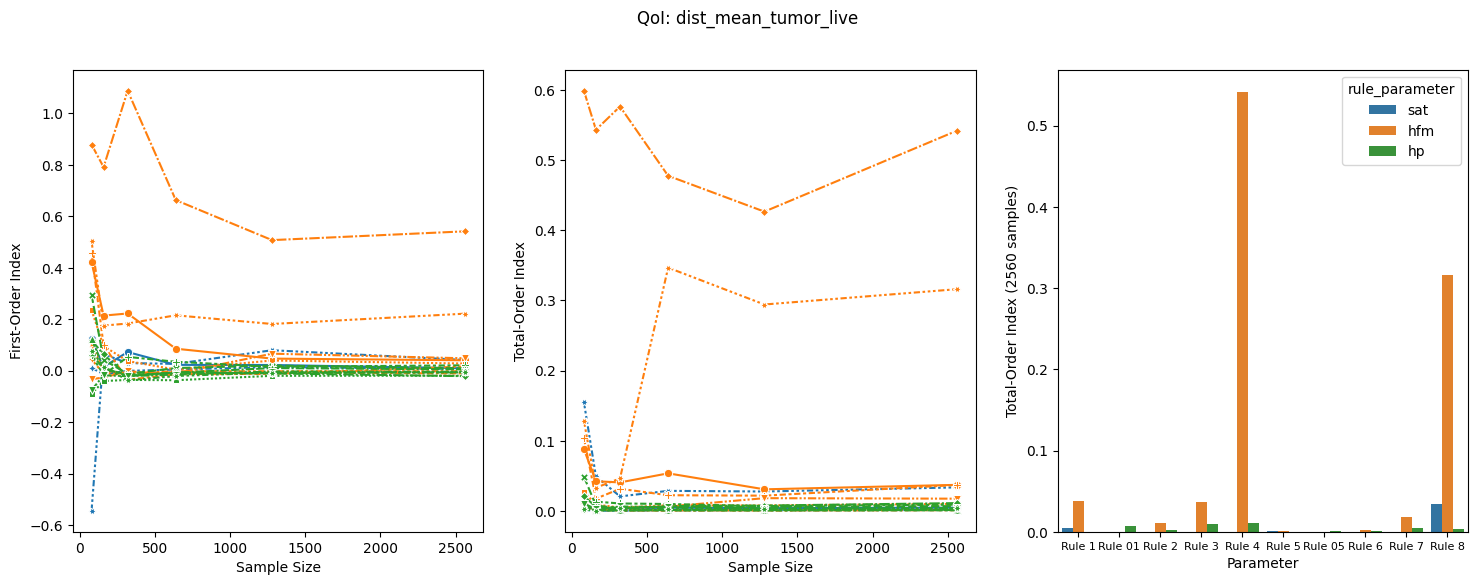

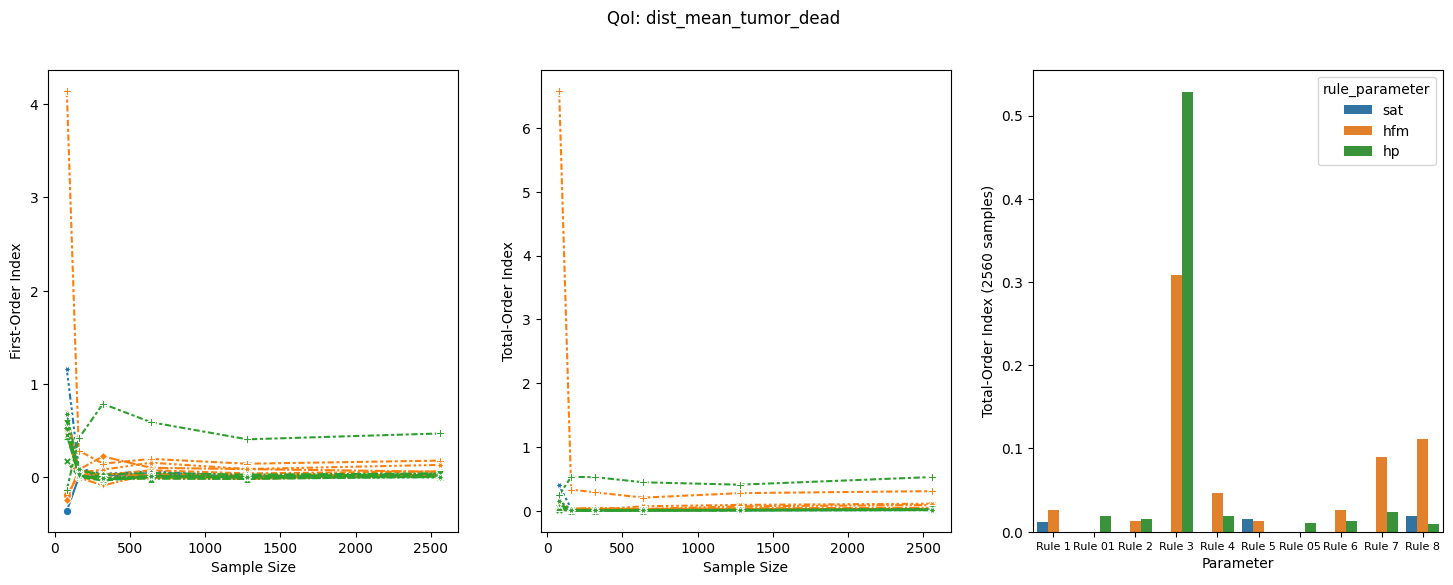

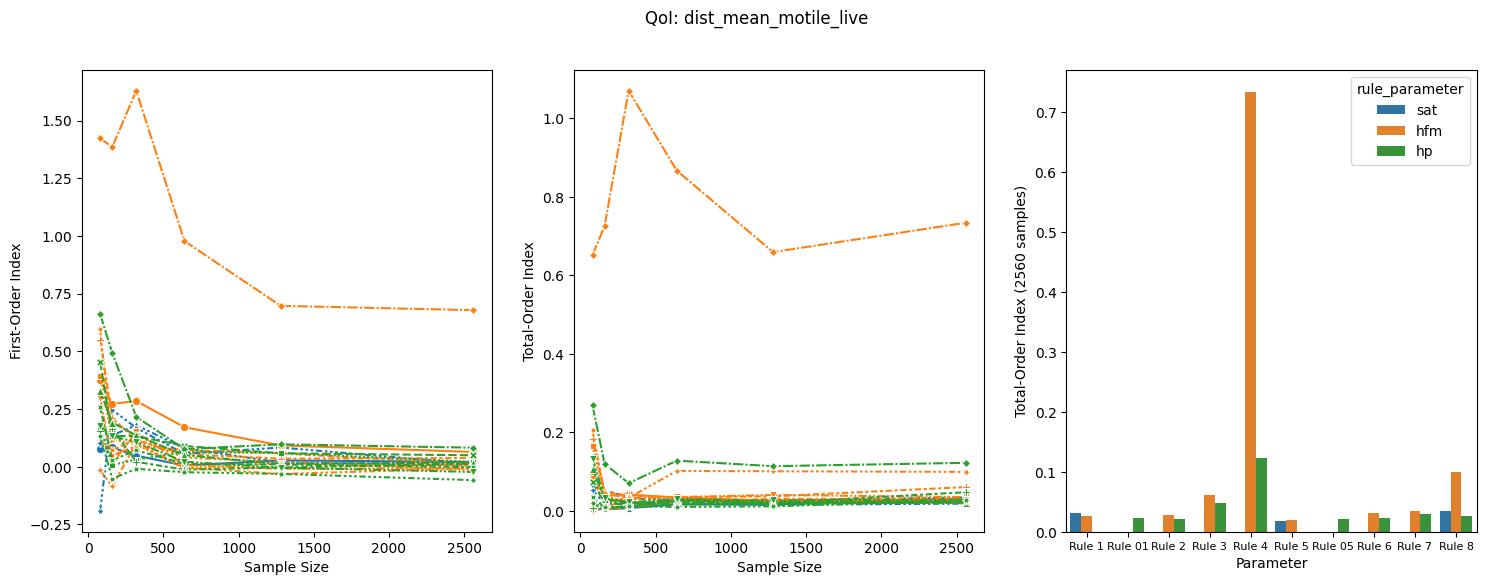

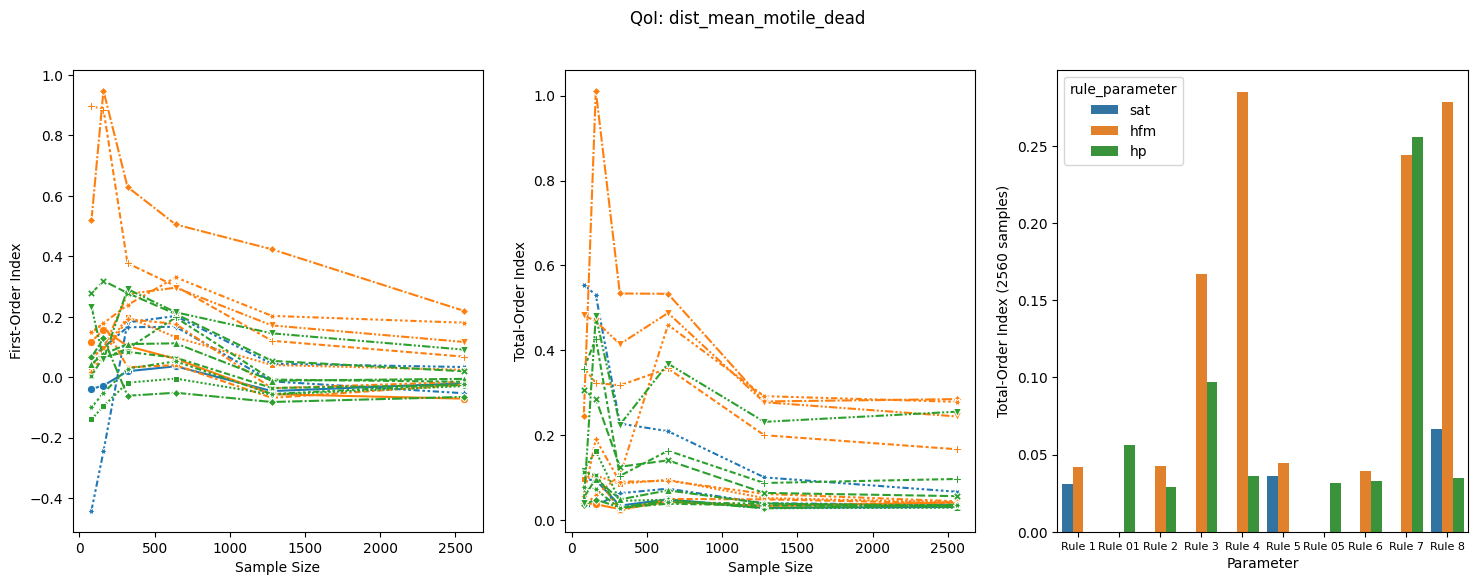

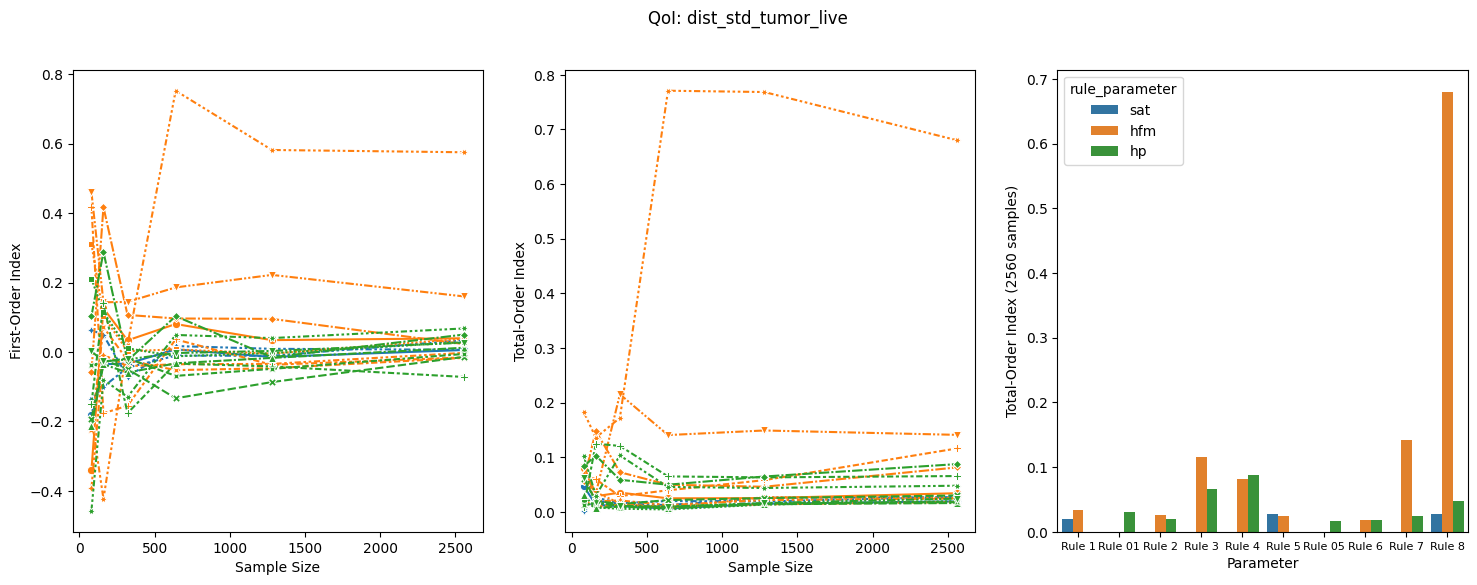

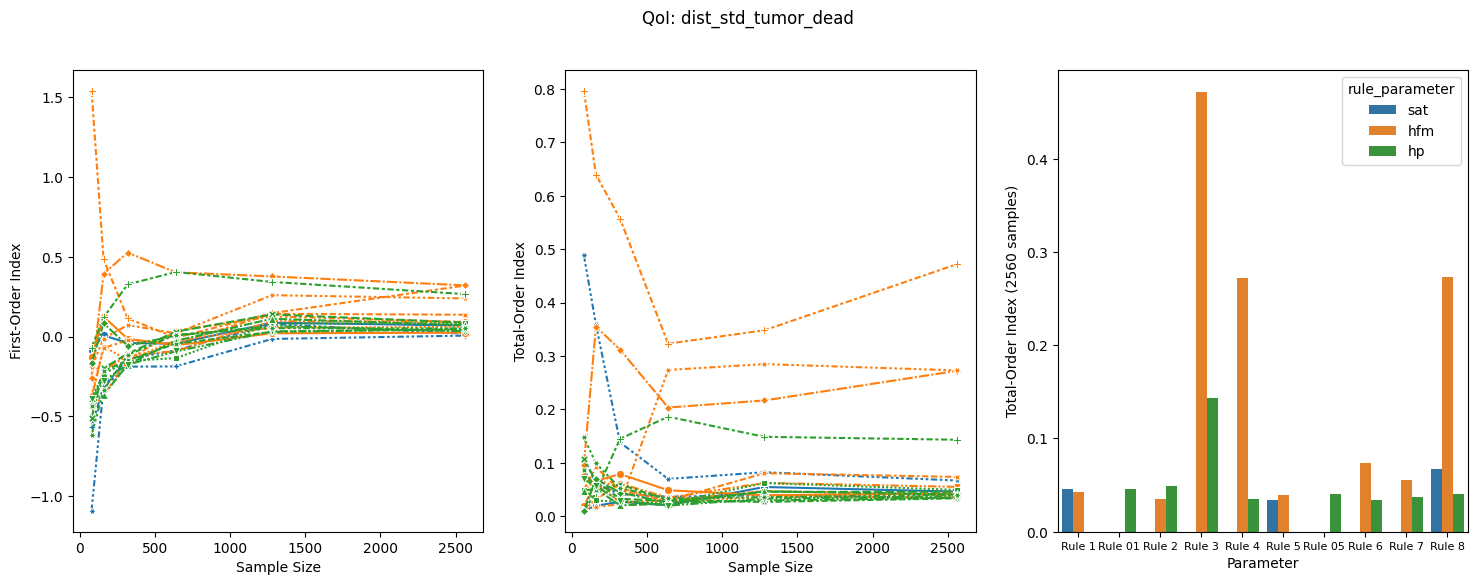

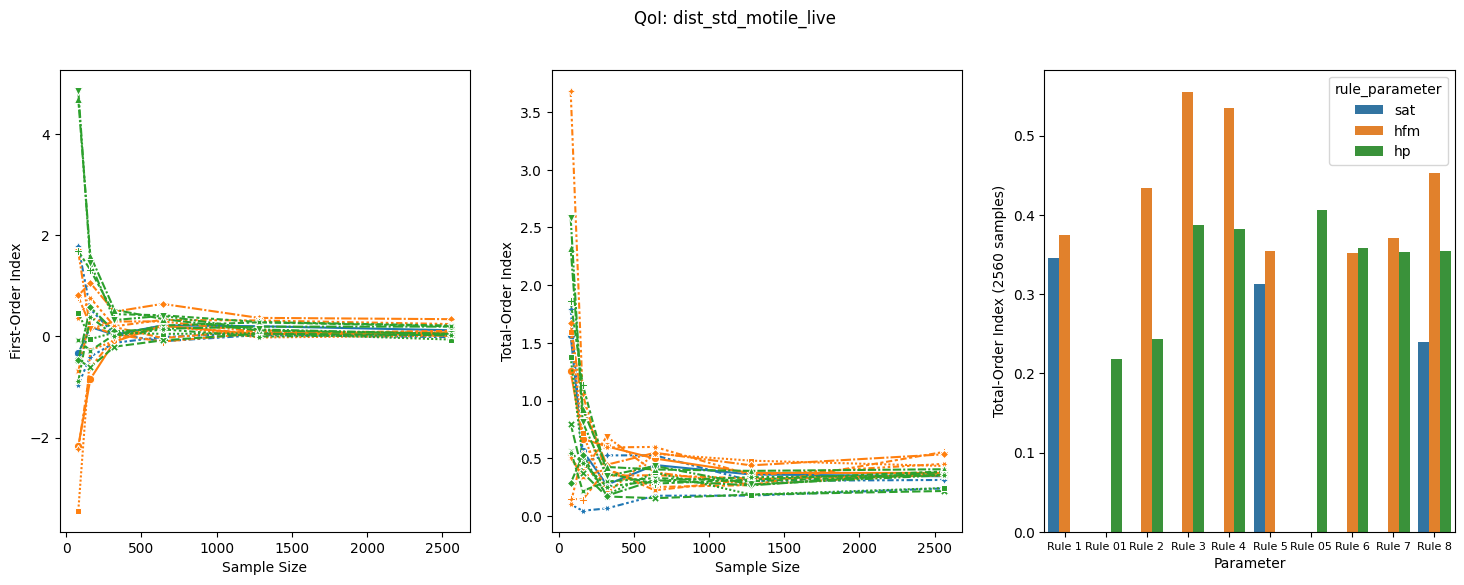

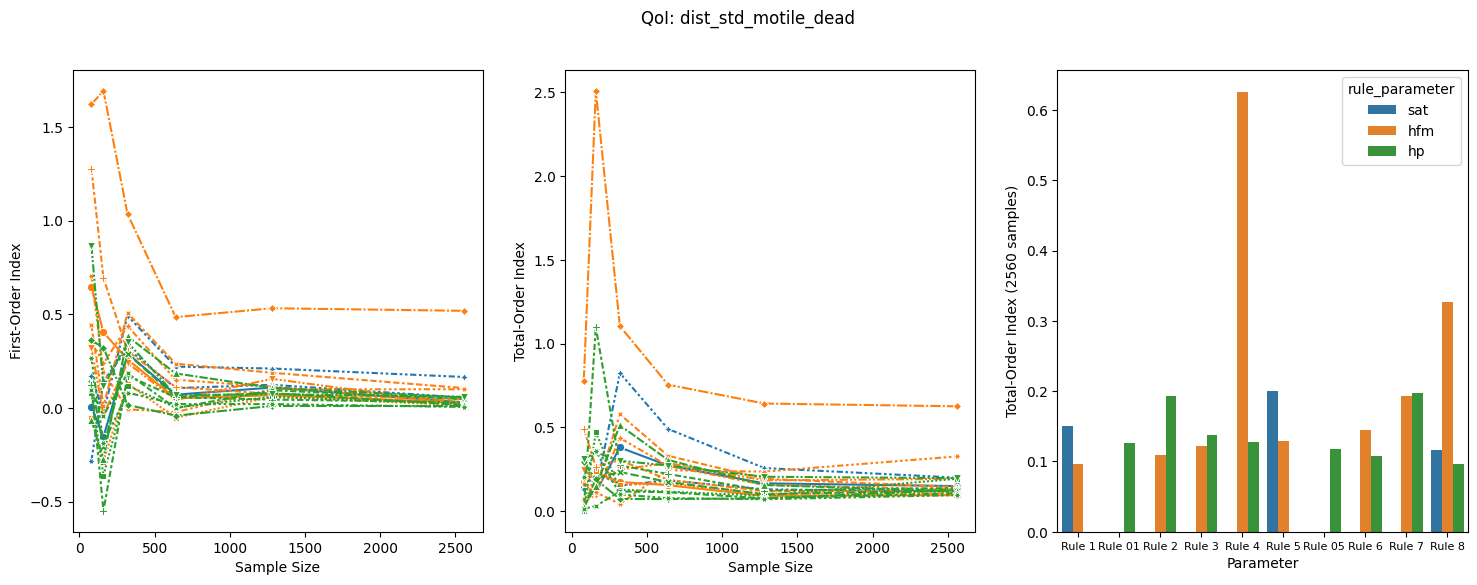

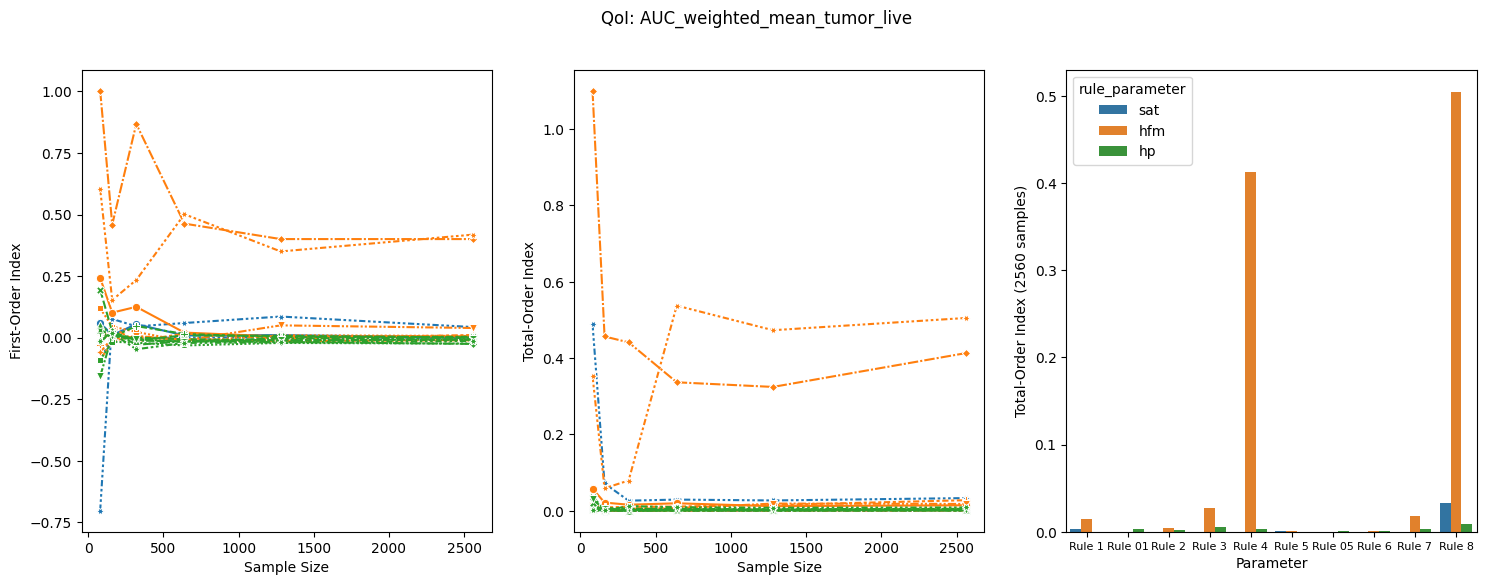

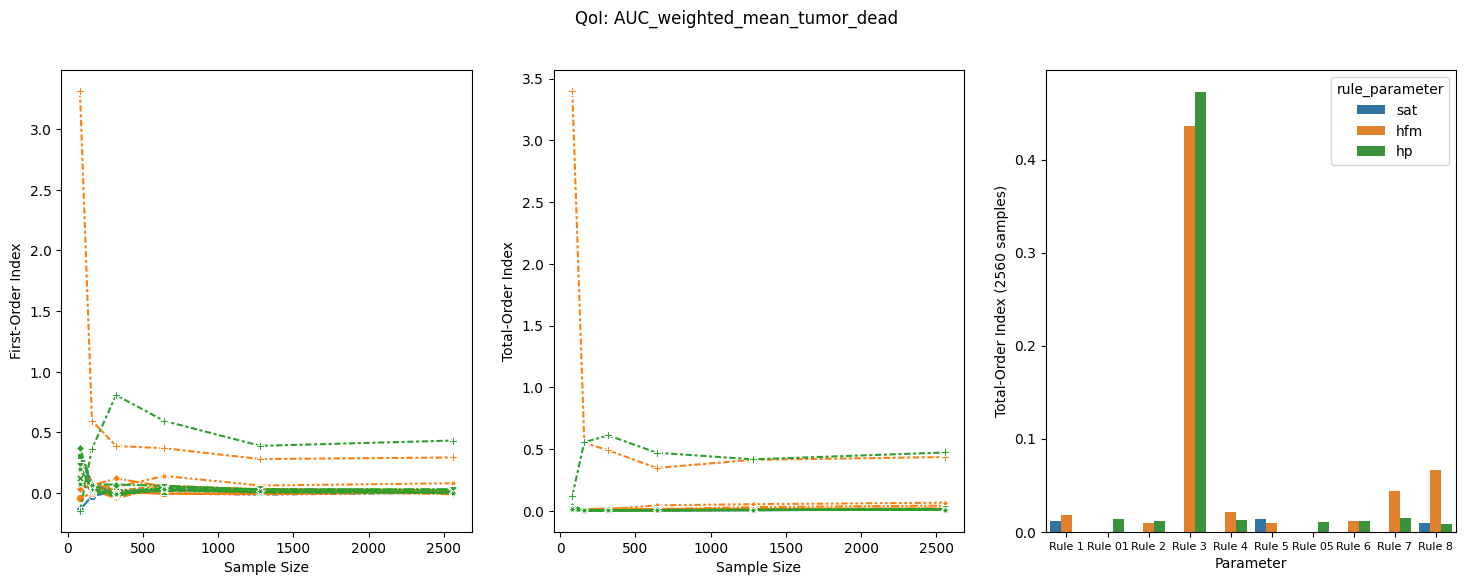

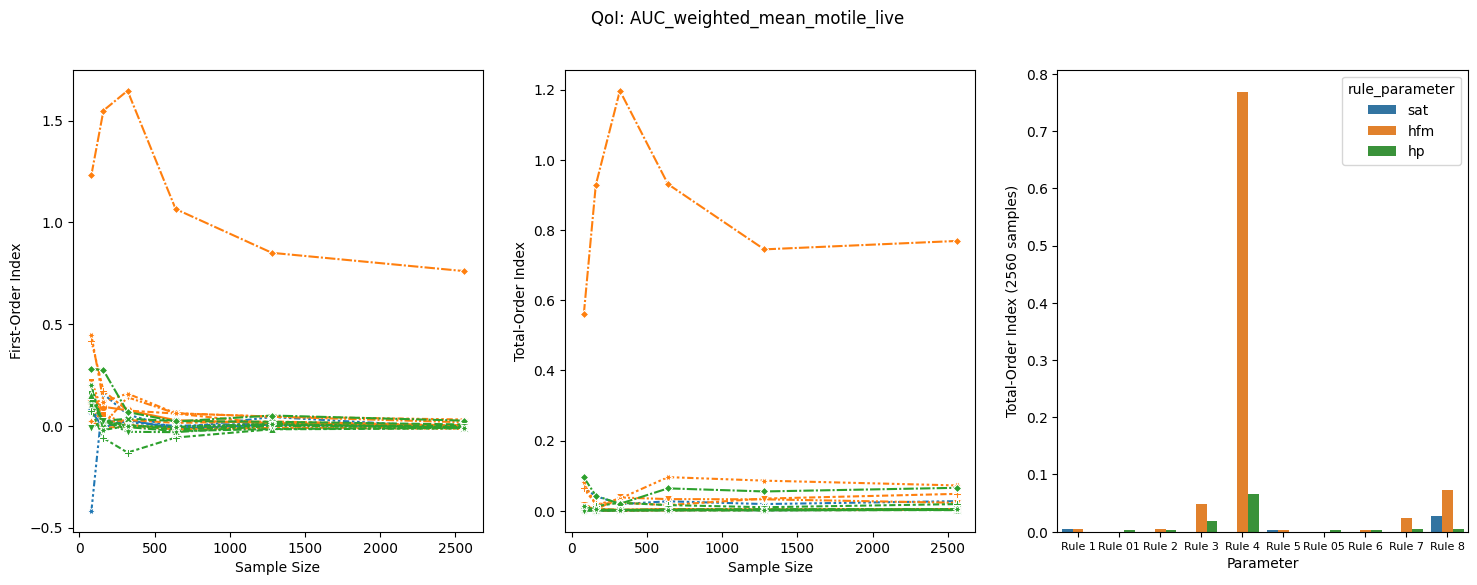

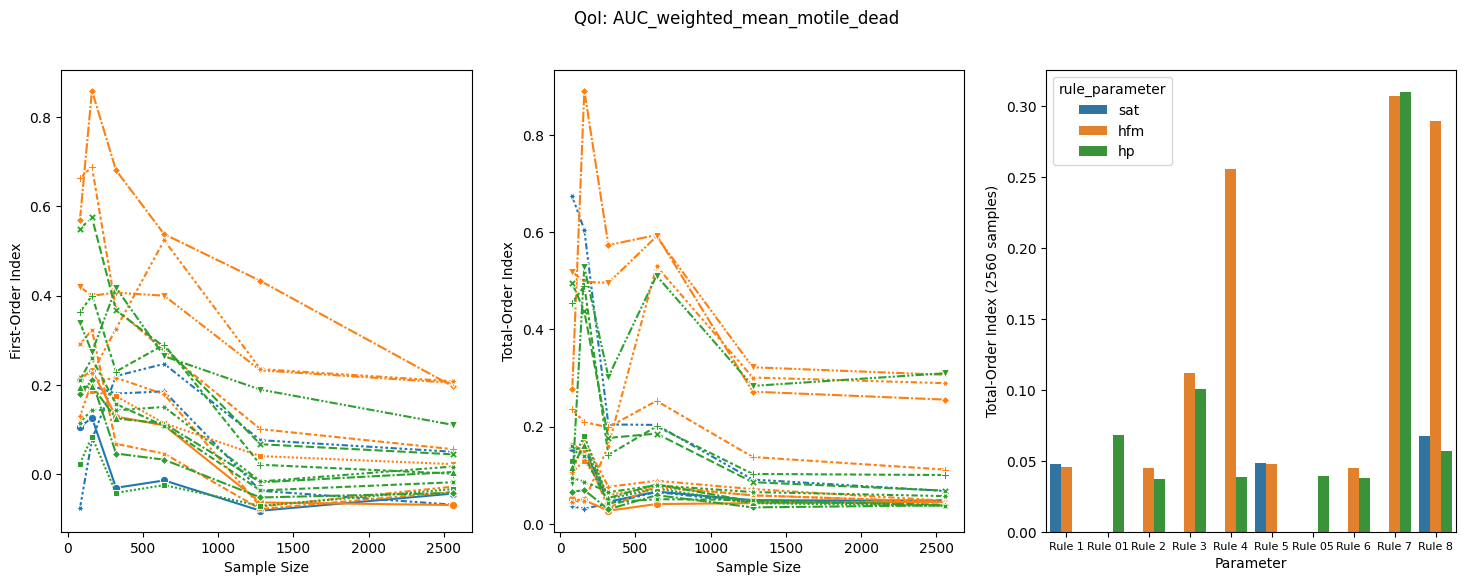

In [9]:
import seaborn as sns

for QOI in dic_analyzes.keys():
    if not np.isnan(dic_analyzes[QOI]['S1_values']).all():
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'QoI: {QOI}')
        
        # rank of 5 most important parameters
        rank_par_idx = np.argsort(dic_analyzes[QOI]['ST_values'][-1, :])[::-1][:5]
        top_parameters = np.array(problem["names"])[rank_par_idx]
        
        # Plotting the indices for each QOI
        df_temp = df_analyzes[ df_analyzes['QOI'] == QOI ]
        sns.lineplot(df_temp, x='sample_size', y='S1', hue='rule_parameter', style='rule_label', ax=axes[0], markers=True, legend=False)
        sns.lineplot(df_temp, x='sample_size', y='ST', hue='rule_parameter', style='rule_label', ax=axes[1], markers=True, legend=False)
        
        axes[0].set_xlabel('Sample Size')
        axes[0].set_ylabel('First-Order Index')
        
        axes[1].set_xlabel('Sample Size')
        axes[1].set_ylabel('Total-Order Index')
        
        sns.barplot(df_temp[ df_temp['sample_size'] == sample_sizes[-1] ], x='rule_label', y='ST', hue='rule_parameter', ax=axes[2])
        axes[2].tick_params(axis='x', labelsize=8)
        axes[2].set_xlabel('Parameter')
        axes[2].set_ylabel(f'Total-Order Index ({sample_sizes[-1]} samples)')
        
        plt.show()
    else:
        print(f'QoI: {QOI} has NaN values')

## Plot the QoIs: mean and std distance from center and AUC of population for each cell type

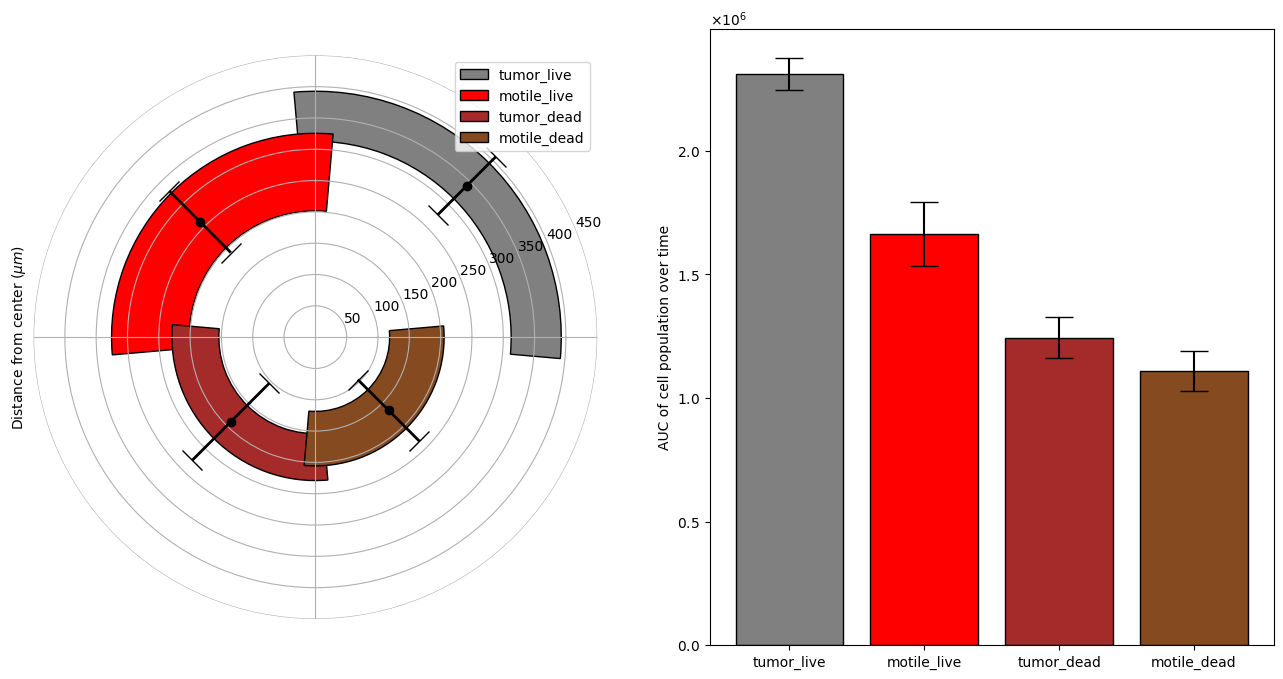

In [10]:
from matplotlib.ticker import FuncFormatter


pop_cols = ['tumor_live', 'motile_live', 'tumor_dead', 'motile_dead']
colors = ['gray','red' , 'brown',(0.52,0.29,0.12) ]

radius_min = np.array([df_summary['dist_mean_'+pop_cols[0]].min(), df_summary['dist_mean_'+pop_cols[1]].min(), df_summary['dist_mean_'+pop_cols[2]].min(), df_summary['dist_mean_'+pop_cols[3]].min()])
radius_mean = np.array([df_summary['dist_mean_'+pop_cols[0]].mean(), df_summary['dist_mean_'+pop_cols[1]].mean(), df_summary['dist_mean_'+pop_cols[2]].mean(), df_summary['dist_mean_'+pop_cols[3]].mean()])
radius_max = np.array([df_summary['dist_mean_'+pop_cols[0]].max(), df_summary['dist_mean_'+pop_cols[1]].max(), df_summary['dist_mean_'+pop_cols[2]].max(), df_summary['dist_mean_'+pop_cols[3]].max()])
err_radius = np.array([df_summary['dist_std_'+pop_cols[0]].mean(), df_summary['dist_std_'+pop_cols[1]].mean(), df_summary['dist_std_'+pop_cols[2]].mean(),  df_summary['dist_std_'+pop_cols[3]].mean()])

theta = np.arange(0,2*np.pi,2*np.pi/len(pop_cols))
width = (2*np.pi/len(pop_cols)) + np.pi/18

aucs = np.array([df_summary['AUC_weighted_mean_'+pop_cols[0]].mean(), df_summary['AUC_weighted_mean_'+pop_cols[1]].mean(), df_summary['AUC_weighted_mean_'+pop_cols[2]].mean(), df_summary['AUC_weighted_mean_'+pop_cols[3]].mean()])
err_aucs = np.array([df_summary['AUC_weighted_mean_'+pop_cols[0]].std(), df_summary['AUC_weighted_mean_'+pop_cols[1]].std(), df_summary['AUC_weighted_mean_'+pop_cols[2]].std(), df_summary['AUC_weighted_mean_'+pop_cols[3]].std()])

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122)

bars = ax1.bar(theta+np.pi/len(pop_cols), radius_max-radius_min, bottom=radius_min, color=colors, label=pop_cols, width=width, edgecolor='black')
bars_mean = ax1.errorbar(theta+np.pi/len(pop_cols), radius_mean, yerr=err_radius, fmt='o', color='black', ecolor='black', elinewidth=2, capsize=10)

ax1.set_ylim(0,450)
ax1.set_ylabel(r'Distance from center ($\mu m$)')
ax1.set_xticks(theta, labels=[])
ax1.spines['polar'].set_visible(False)

ax2.bar(pop_cols, aucs, yerr=err_aucs, capsize=10, color=colors, edgecolor='black')
ax2.set_ylabel('AUC of cell population over time')
ax2.yaxis.major.formatter._useMathText = True #(make x10^n)

ax1.legend()
plt.show()